# Lab 4 - Linear models

We focus on models in the form 

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

or in generalized form (generalized linear models)

$$ f(y) ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

where $f(y)$ is a link function, for example - logit.


In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
model_ppc=CmdStanModel(stan_file='stan_files/height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 1. Prior predictive checks

1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors
4. Check if observed data is possible to obtain using priors.

In [4]:
def plt_hist(stan_fit,var_name, bins):
    plt.hist(stan_fit.stan_variable(var_name), bins=bins)
    plt.title("Histogram of var: {}".format(var_name))
    plt.show()

In [5]:
def plt_joint_dist(stan_fit, var1, var2):
    plt.scatter(stan_fit.stan_variable(var1), stan_fit.stan_variable(var2))
    plt.title("Joint dist of vars: {}, {}".format(var1, var2))
    plt.show()  

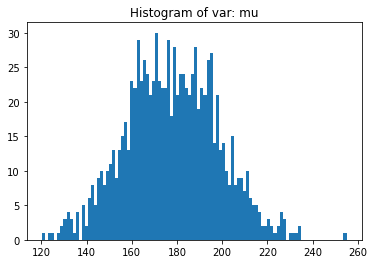

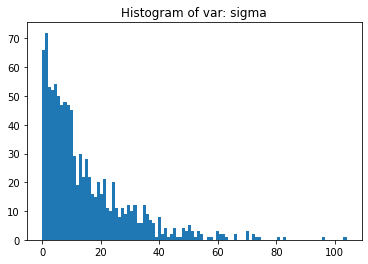

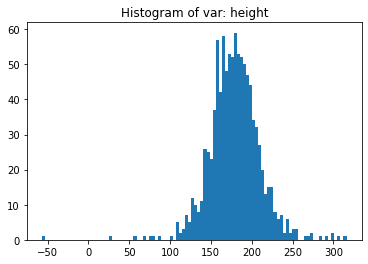

In [6]:
var_names = ['mu', 'sigma', 'height']
bins = 100

for v in var_names:
    plt_hist(sim, v, bins)

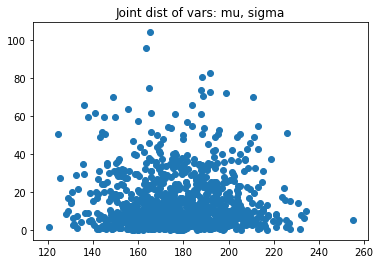

In [7]:
plt_joint_dist(sim, "mu", "sigma")

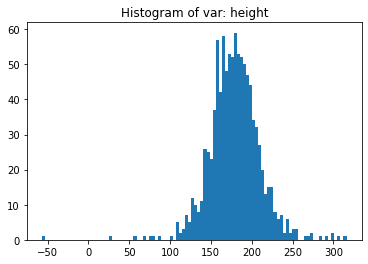

<AxesSubplot:>

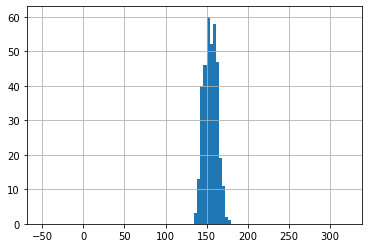

In [8]:
plt_hist(sim, 'height', 100)

d.height.hist(bins=100, range=[-50,320])

In [9]:
model_1_fit=CmdStanModel(stan_file='stan_files/height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [10]:
fit=model_1_fit.sample(data=dict(N=len(d),
                        heights=d.height.values),
                        seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [33]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-900.0,0.0250,0.98,-900.0,-900.0,-900.0,1600.0,14000.0,1.0
mu,150.0,0.0074,0.41,150.0,150.0,160.0,3100.0,27000.0,1.0
sigma,7.8,0.0050,0.29,7.3,7.8,8.3,3400.0,30000.0,1.0
height,150.0,0.1200,7.60,140.0,150.0,170.0,4200.0,37000.0,1.0


#### Task 2. Model fit and evaluation

1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.



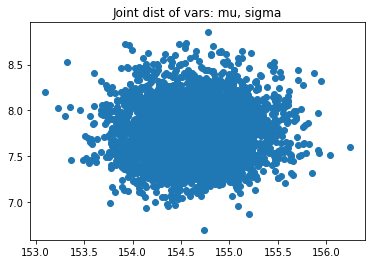

In [12]:
plt_joint_dist(fit, 'mu', 'sigma')

In [13]:
def two_hist_plot(stan_fit1,var_name1, stan_fit2,var_name2, bins):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.hist(stan_fit1.stan_variable(var_name1), bins=bins)
    ax1.set_title("Hist of fit: {} and var: {}".format("sim",var_name1))
    ax2.hist(stan_fit2.stan_variable(var_name2), bins=bins)
    ax2.set_title("Hist of fit: {} and var: {}".format('fit',var_name2))
    plt.show()

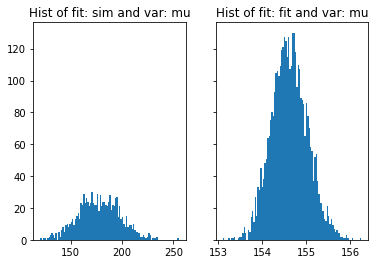

In [14]:
two_hist_plot(sim, 'mu', fit, 'mu', 100)

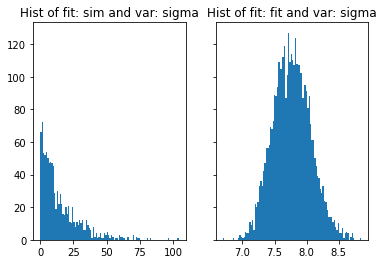

In [15]:
two_hist_plot(sim, 'sigma', fit, 'sigma', 100)

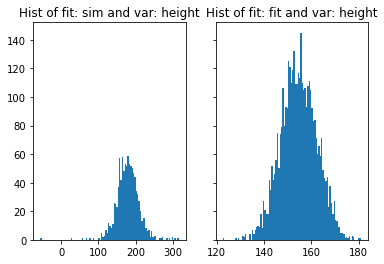

In [16]:
two_hist_plot(sim, 'height', fit, 'height', 100)

### Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [39]:
w_mean = d["weight"].mean()
d["c_weight"] = d["weight"] - w_mean

In [46]:
weight = np.linspace(d.c_weight.min(),d.c_weight.max())

print(weight)
print(len(weight))

[-13.91943352 -13.26797358 -12.61651364 -11.9650537  -11.31359376
 -10.66213383 -10.01067389  -9.35921395  -8.70775401  -8.05629407
  -7.40483413  -6.75337419  -6.10191425  -5.45045432  -4.79899438
  -4.14753444  -3.4960745   -2.84461456  -2.19315462  -1.54169468
  -0.89023474  -0.23877481   0.41268513   1.06414507   1.71560501
   2.36706495   3.01852489   3.66998483   4.32144477   4.9729047
   5.62436464   6.27582458   6.92728452   7.57874446   8.2302044
   8.88166434   9.53312428  10.18458421  10.83604415  11.48750409
  12.13896403  12.79042397  13.44188391  14.09334385  14.74480379
  15.39626373  16.04772366  16.6991836   17.35064354  18.00210348]
50


In [55]:
model_ppc=CmdStanModel(stan_file='stan_files/height_2a_ppc.stan')
R = 1000
data_sim={'N':50, 'weight':weight}


INFO:cmdstanpy:found newer exe file, not recompiling


In [56]:

sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [57]:
sim.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.00,NaN,0,0.00,0.00,0.0,NaN,NaN,NaN
alpha,180.00,0.64,20,150.00,180.00,210.0,990.0,22000.0,1.0
beta,0.21,0.35,10,-17.00,-0.37,17.0,850.0,19000.0,1.0
sigma,15.00,0.45,15,0.72,10.00,45.0,1100.0,24000.0,1.0
height[1],175.00,4.90,143,-56.00,181.00,417.0,860.0,19536.0,1.0
height[2],176.00,4.60,137,-38.00,185.00,407.0,871.0,19803.0,1.0
height[3],175.00,4.50,129,-34.00,179.00,388.0,828.0,18817.0,1.0
height[4],176.00,4.20,123,-24.00,184.00,391.0,856.0,19455.0,1.0
height[5],175.00,4.00,118,-8.50,181.00,370.0,858.0,19508.0,1.0


#### Task 4. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

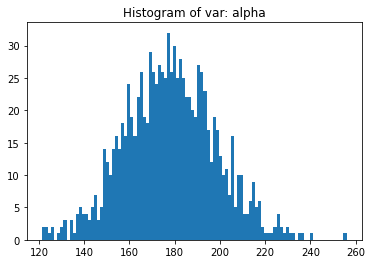

In [59]:
plt_hist(sim, 'alpha', bins)

### Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [29]:
model_ppc=CmdStanModel(stan_file='stan_files/height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [28]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 5. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [60]:
# robicie se fora, w tym forze zakłdamy max min i 3 kwantyle (5 list) 
# do każdej lity append wyliczamy kwantyle, potem plotujemy listy



### Fitting data


In [61]:
model_2_fit=CmdStanModel(stan_file='stan_files/height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


#### Task 6. Preparing data for fit
1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [25]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)


NameError: name 'data_fit' is not defined

#### Task 7. Evaluating model

1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.
